# ***Quantum Experience Demo: Solving an Optimization Problem by using Qiskit Runtime***
**Qiskit Runtime is used to solve an illustrative combinatorial optimization problem on quantum computers, examining an example from Max-Cut solved with the hybrid quantum variational algorithm VQE.**



### Authors:
_Dr. Stefan Kister_<br>
IBM Quantum Technical Ambassador, IBM DACH - Düsseldorf<br> 
<br>
_Dr. Thorsten Muehge_<br>
IBM Quantum Technical Ambassador, IBM DACH - Frankfurt<br> 
<br>
Last update on 2.August, 2023
    

# 1. Introduction

# **<center>Optimization – general aspects and challenges</center>**
![Optimization Classical View](./images/optimization_classic_quantum.png)

# 2. Using qiskit to solve an optimization problem

## Qiskit Architecture
![Qiskit Optimization Module](./images/qiskit-architecture-overview.svg)

## Qiskit Optimization Module
![Qiskit Optimization Module](./images/qiskit_optimization_module.png)
https://qiskit.org/documentation/optimization/

## Variational Quantum Algorithm
![Variational Quantum Algorithm](./images/vqa_intro.png)

## Transform QUBO Problem to Quantum
![Variational Quantum Algorithm](./images/qubo_to_quantum.png)

In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

/var/folders/xp/_lkpwwss4kz10m14lgzy2p5m0000gp/T/ipykernel_3973/532143317.py:11: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import VQE, NumPyMinimumEigensolver


## 2.1. Example for an Optimization Problem: 

### Weighted Max Cut Problem:

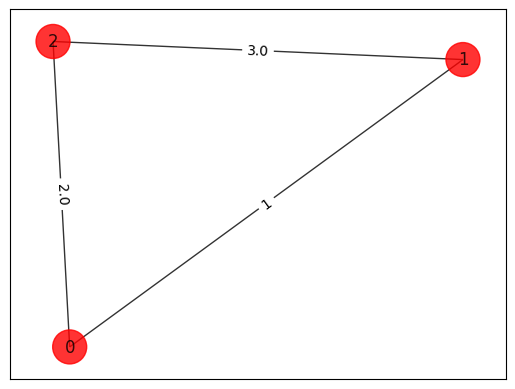

In [2]:
# Generating a graph of 3 nodes 

n=3 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1),(0,2,2.0),(1,2,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)

Nodes and edges.

Here we have $n = 3$ red nodes edges.

Each edge carries a weight.

The weights of the edges are 2.0, 3.0 and 1.0 respectively.

### Make an example cut:

#### Separate node 0 from node 1 and node 2


Cost = 1 + 2 =  3


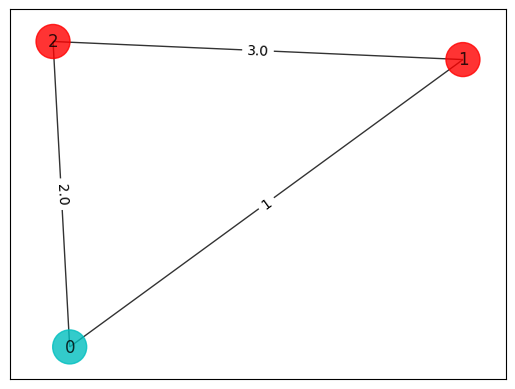

In [3]:
xbest_brute = [1,0,0]
colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

print('\nCost = 1 + 2 = ', 1+2)

red is mapped to 0

blue is mapped to 1

here we have [1, 0, 0]

### The goal is to find the ultimate cut that gives the highest cost (maximization problem).

## Weighted Max-Cut Examples:

1) Optimize layout of electronic circuits

2) Design verification

3) Production scheduling optimization

4) Yield Optimization

5) Supply chain optimizing

6) Supply chain disruption recovery

and more

## 2.2. Calculating the Max-Cut problem using the Brute force approach

Try all possible $2^n$ combinations. 

For $n = 3$ -> 8 combinations (as in the present example)

For $n = 10$ -> 1024 combinations

For $n = 50$ -> 1 125 899 906 842 624

For $n = 127$ -> 170 141 183 460 469 231 731 687 303 715 884 105 728

For $n = 275 $ -> 60 708 402,882 054,033 466 233 184 588 234 965 832 575 213 720 379 360 039 119 137 804 340 758 912 662 765 568 

($\approx$ 6.1 x $10^{82}$) More combinations than there are Atoms in the observable Universe. 

This is a hard problem.

***Classically the solution of the Max-Cut problem requires resources that scale exponetially with the number of nodes.***

In [4]:
# Computing the weight matrix from the above 3-node example
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 2.]
 [1. 0. 3.]
 [2. 3. 0.]]


case = [0, 0, 0] cost = 0.0
case = [1, 0, 0] cost = 3.0
case = [0, 1, 0] cost = 4.0
case = [1, 1, 0] cost = 5.0
case = [0, 0, 1] cost = 5.0
case = [1, 0, 1] cost = 4.0
case = [0, 1, 1] cost = 3.0
case = [1, 1, 1] cost = 0.0

Best solution = [1, 1, 0] cost = 5.0


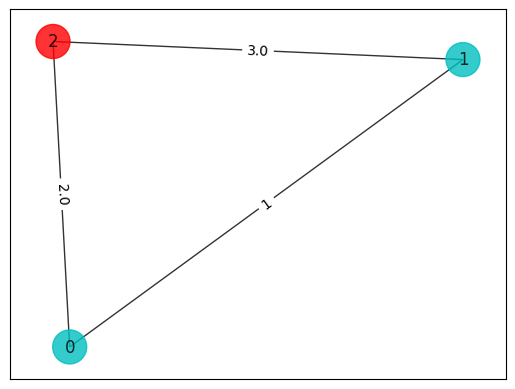

In [5]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

## 2.3. Mapping the Classical Max-Cut Problem to a Quantum Problem

In [26]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp)

maximize -2*x_0*x_1 - 4*x_0*x_2 - 6*x_1*x_2 + 3*x_0 + 4*x_1 + 5*x_2 (3 variables, 0 constraints, 'Max-cut')


In [27]:
IsingOperator, offset = qp.to_ising()
print('Offset:', offset)
print('Ising Hamiltonian:')
print(str(IsingOperator))

Offset: -3.0
Ising Hamiltonian:
SparsePauliOp(['IZZ', 'ZIZ', 'ZZI'],
              coeffs=[0.5+0.j, 1. +0.j, 1.5+0.j])


energy: -2.0
max-cut objective: 5.0
solution: [1. 1. 0.]
solution objective: 5.0


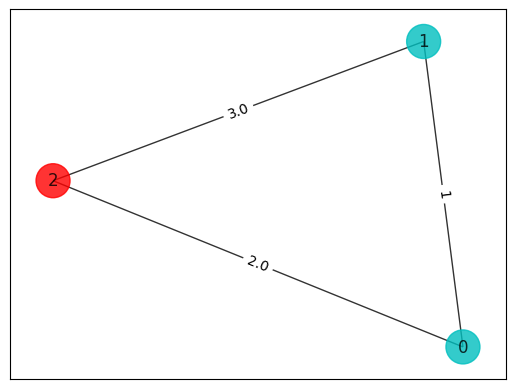

In [28]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector classically
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(IsingOperator)

x = max_cut.sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', -result.eigenvalue.real - offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

## 3. Running it on quantum computer

## 3.1 Using Variational Quantum Eigensolver (VQE)

![Variational Quantum Algorithm](./images/vqe_method.png)

Source: Ioannis Kolotouros, Petros Wallder, "An evolving objective function for improved variational quantum optimisation", e-print arXiv 2105.11766

## 3.1. Defining classic optimizer and preparing VQE trial state (Ansatz)

### Set up the Qiskit runtime service using the Estimator and Sampler primitives

In [29]:
from qiskit.primitives import Sampler, Estimator

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
provider.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>]

In [30]:
backend = provider.get_backend('ibmq_qasm_simulator')
sampler = Sampler(options = {"backend": 'ibmq_qasm_simulator'})
estimator = Estimator(options = {"backend": 'ibmq_qasm_simulator'})

## 3.2. Using VQE with Qiskit runtime on a quantum device

## Qiskit Runtime 
![Qiskit Runtime](./images/runtime-architecture.png)
https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html

### Primitives - Sampler and Estimator
| Primitive      | Description | Example output   |
| :---        |    :---   |          :--- |
| Sampler      | Allows a user to input a circuit and then generate quasiprobabilities. This generation enables users to more efficiently evaluate the possibility of multiple relevant data points in the context of destructive interference.       | ![Sampler](./images/sampler.png) |
| Estimator   | Allows a user to specify a list of circuits and observables and selectively group between the lists to efficiently evaluate expectation values and variances for a parameter input. It is designed to enable users to efficiently calculate and interpret expectation values of quantum operators that are required for many algorithms.        |  ![Sampler](./images/estimator.png)   |



### 3.2.1. Defining VQE and running it on an IBM Quantum Simulator

/Users/stefan.kister/opt/virtual/qiskit/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


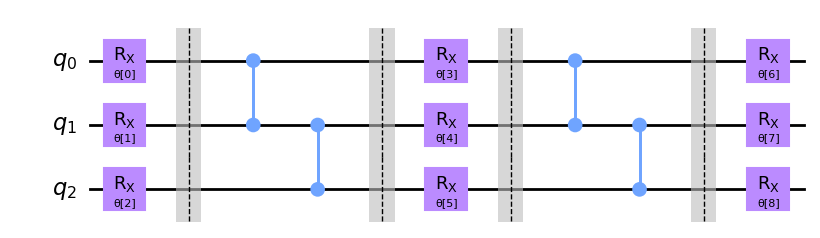

In [31]:
from qiskit.circuit.library import TwoLocal

num_qubits = IsingOperator.num_qubits

ansatz = TwoLocal(num_qubits, "rx", "cz", reps=2, entanglement="linear", insert_barriers = True)

ansatz.decompose().draw('mpl')

In [32]:
from qiskit.algorithms.optimizers import SPSA
from qiskit.primitives import Sampler, Estimator


estimator = Estimator()


history = {"nfevs": [], "points": [], "fvals": [], "updates": [], "accepted": []}
num_iter = 75

job_list = []

estimator = Estimator()
def evaluate_expectation(x):
    x = list(x)
    result = estimator.run(circuits=ansatz, backend_options="statevector", observables=IsingOperator, parameter_values=[x]).result()
    results = result.values[0] 
    job_list.append(result)
    return np.real(results)

def callback(nfev, point, fval, update, accepted):
    print('calculated cost: {}'.format(-fval-offset))
    history["nfevs"].append(nfev)
    history["points"].append(point)
    history["fvals"].append(-fval-offset)
    history["updates"].append(update)
    history["accepted"].append(accepted)    

np.random.seed(42)
initial_point = np.random.random(ansatz.num_parameters)
optimizer = SPSA(num_iter, callback=callback)
result = optimizer.minimize(fun=evaluate_expectation, x0=initial_point)

calculated cost: 3.5785667188811536
calculated cost: 4.104821864548146
calculated cost: 4.2097905853806745
calculated cost: 4.2955762633816015
calculated cost: 4.296268138779466
calculated cost: 4.27967676182824
calculated cost: 4.434539213589724
calculated cost: 4.50111962031504
calculated cost: 4.587694034033736
calculated cost: 4.5895307471793645
calculated cost: 4.592211578952465
calculated cost: 4.6160180782381826
calculated cost: 4.712363403197369
calculated cost: 4.7463848546683725
calculated cost: 4.758670470382682
calculated cost: 4.77721803371815
calculated cost: 4.781307759076644
calculated cost: 4.788899924286964
calculated cost: 4.79337953494549
calculated cost: 4.793435036997254
calculated cost: 4.810281772811182
calculated cost: 4.813337947119592
calculated cost: 4.825673748486577
calculated cost: 4.833691520823015
calculated cost: 4.835124594526725
calculated cost: 4.872544006457827
calculated cost: 4.877315711655578
calculated cost: 4.877738401632164
calculated cost: 4

In [13]:
print('optimized circuit parameters:\n{}'.format(result.x))
print()
print('Objective Value =', history['fvals'][num_iter - 1])

optimized circuit parameters:
[ 1.18732215  0.59127337 -0.11410829  0.4227846  -0.24446975 -0.73730266
  1.51022413  2.66283344  0.7637898 ]

Objective Value = 4.9651589295616825


### Use the Sampler primitive to get bitstrings from the approx ground state

/Users/stefan.kister/opt/virtual/qiskit/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


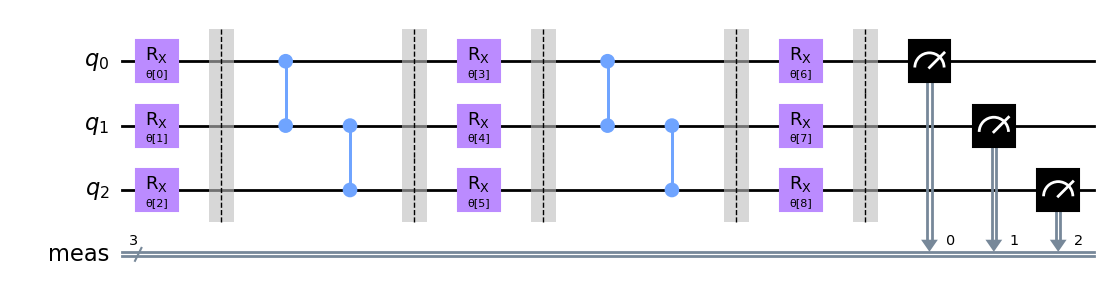

In [14]:
ansatz.measure_all()
ansatz.decompose().draw('mpl')

In [15]:
sampler = Sampler()

strings = sampler.run(circuits=ansatz, parameter_values=[result.x], shots=8000, backend_options="statevector").result()

In [16]:
bitstrings = strings.quasi_dists[0].binary_probabilities()
print(bitstrings)

{'001': 0.000625, '010': 0.002, '011': 0.968125, '101': 0.02925}


In [17]:
# Extract best solution
from operator import itemgetter
bitstring_list = [(k, v) for k, v in bitstrings.items()]
best_solution = sorted(bitstring_list, key=itemgetter(1), reverse = True)[0]
best_solution_string = best_solution[0]

# Convert bitstring
bitstring = []
for k in range(num_qubits):
    bitstring.append(best_solution_string[k])

bitstr = [int(x) for x in bitstring]

print('Best Solution:')
print(best_solution)
#print(bitstring)

Best Solution:
('011', 0.968125)



Optimization Summary - Results:
Objective Value = 4.9651589295616825
Best Solution [0, 1, 1]



Text(0.5, 0.98, 'Optimization Summary - Graphics')

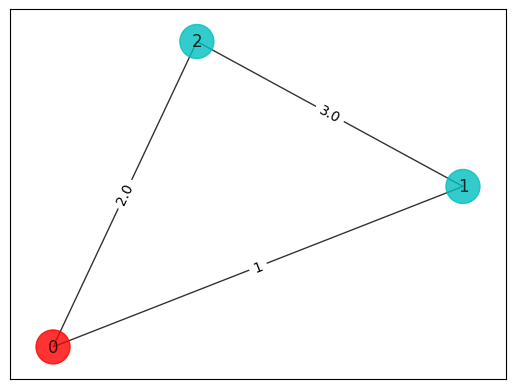

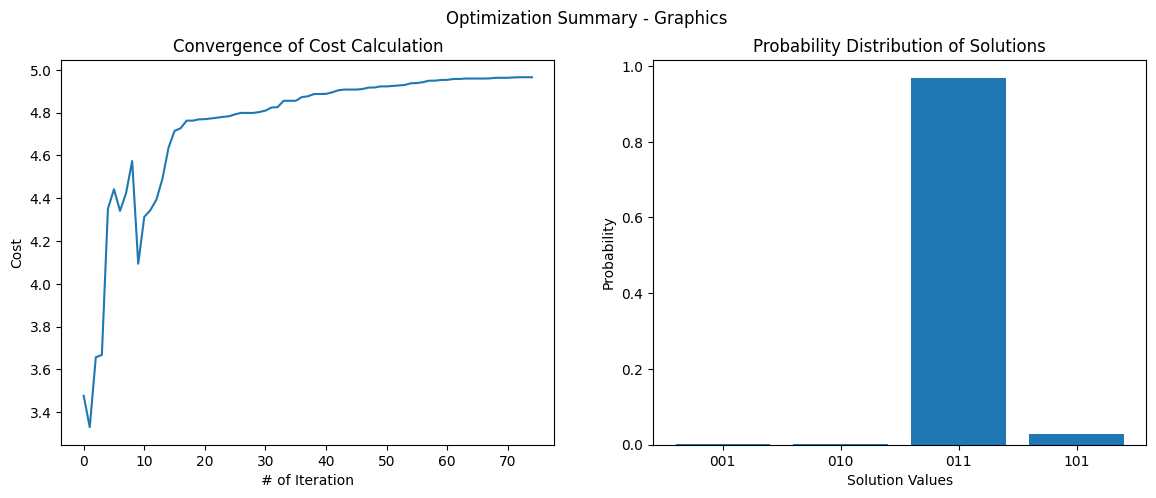

In [18]:
import matplotlib.pyplot as plt
print()
print('Optimization Summary - Results:')
print('Objective Value =', history['fvals'][num_iter - 1])
print('Best Solution', bitstr)
print()

qbest = bitstr
colors = ['r' if qbest[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
    
fig, axs = plt.subplots(1,2, figsize=(14, 5))
axs[0].plot(history['fvals'])
axs[1].bar(list(bitstrings.keys()), list(bitstrings.values()))
axs[0].set_xlabel("# of Iteration")
axs[0].set_ylabel("Cost")
axs[0].set_title("Convergence of Cost Calculation")
axs[1].set_xlabel("Solution Values")
axs[1].set_ylabel("Probability")
axs[1].set_title("Probability Distribution of Solutions")

fig.suptitle('Optimization Summary - Graphics')


**References:**

Qiskit Runtime overview:

https://qiskit.org/documentation/partners/qiskit_ibm_runtime/

Variational Quantum Algorithms with Qiskit Runtime: Combinatorial Optimization 

https://github.com/jenglick/scipy22-qiskit-runtime-tutorial/blob/main/docs/tutorials/Part3_VQA_Optimization_EXERCISE-Solution.ipynb

Optimization Tutorials:

https://qiskit.org/documentation/optimization/tutorials/index.html



In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright